# Model Training and Performance

In [0]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, udf
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, OneHotEncoder, PCA
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import FloatType, DoubleType, StructType, StructField, StringType, IntegerType
from pyspark.ml.feature import Imputer
from graphframes import *
from joblibspark import register_spark
from joblib import Parallel, delayed

from sparkdl.xgboost import XgboostClassifier

spark.sparkContext.addPyFile("dbfs:/custom_cv.py")
from custom_cv import CustomCrossValidator
 
sqlContext = SQLContext(sc)

In [0]:
# Configuration for Blob Storage 

blob_container = "container1" # The name of your container created in https://portal.azure.com
storage_account = "w261sp22team12" # The name of your Storage account created in https://portal.azure.com
secret_scope = "s1" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "k1" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

In [0]:
# SAS Token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# Set partitions
spark.conf.set("spark.sql.shuffle.partitions", 1000)
spark.conf.set("spark.sql.files.minPartitionNum", 1000)

In [0]:
spark

Out[5]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

In [0]:
def sparkShape(dataFrame):
    return (dataFrame.count(), len(dataFrame.columns))

In [0]:
def mergeDataframes(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [0]:
pd.set_option('display.max_columns', None)

## Data

### Airlines and Weather

In [0]:
df_airlines_weather_agg = spark.read.parquet(f"{blob_url}/airlines_agg") \
                                    .repartition(1000, 'fl_date') \
                                    .persist()

In [0]:
df_airlines_weather_2015_2018 = df_airlines_weather_agg.filter(col('year') < 2019).persist()
df_airlines_weather_2019 = df_airlines_weather_agg.filter(col('year') >= 2019).persist()

### Summary

In [0]:
print("airlines_weather_agg 2015-2018", sparkShape(df_airlines_weather_2015_2018))
print("airlines_weather_agg 2019", sparkShape(df_airlines_weather_2019))

airlines_weather_agg 2015-2018 (22020767, 67)
airlines_weather_agg 2019 (6716388, 67)

In [0]:
df_airlines_weather_2015_2018.createOrReplaceTempView('airlines_weather_2015_2018')
df_airlines_weather_2019.createOrReplaceTempView('airlines_weather_2019')

In [0]:
display(df_airlines_weather_2015_2018.groupby(col('year')).count())

year,count
2018,6549587
2017,5113184
2016,5083246
2015,5274750


## Feature Analysis

In [0]:
# Using only airlines data

## 7 one-hot encoded features
ohe_features = [
    'quarter',
    'month',
    'day_of_month',
    'day_of_week',
    'op_carrier_airline_id',
    'dwnd_blk'
]

## 14 airline features
airline_features = [   
    'distance',
    
    'airport_total_flights_pwnd',
    'airport_delayed_flights_pwnd',
    'airport_delayed_mins_pwnd',
    'airport_pct_flight_delayed',
    
    'airline_total_flights_pwnd',
    'airline_delayed_flights_pwnd',
    'airline_delayed_mins_pwnd',
    'airline_pct_flight_delayed',
    
    'ripple_effect_delay',
    'timediff_prev_flight',
    
    'airport_pagerank',
]

## 39 weather features
weather_features = [
    'avg_wind_directional_angle',
    'avg_wind_directional_speed_rate',
    'avg_sky_ceiling_height_dimension',
    'avg_vis_distance',
    'avg_air_temperature',
    'avg_dew_point_temperature',
    'avg_sea_level_pressure',
    'avg_lp_period_qty',
    'avg_ap_altimeter_setting_rate',
    'avg_sky_height_dimension',
    'avg_sky_convective_cloud_attribute',
    'avg_snow_depth_dimension',
    'avg_snow_depth_equivalent_water_depth',

    'min_wind_directional_angle',
    'min_wind_directional_speed_rate',
    'min_sky_ceiling_height_dimension',
    'min_vis_distance',
    'min_air_temperature',
    'min_dew_point_temperature',
    'min_sea_level_pressure',
    'min_lp_period_qty',
    'min_ap_altimeter_setting_rate',
    'min_sky_height_dimension',
    'min_sky_convective_cloud_attribute',
    'min_snow_depth_dimension',
    'min_snow_depth_equivalent_water_depth', 
    
    'max_wind_directional_angle',
    'max_wind_directional_speed_rate',
    'max_sky_ceiling_height_dimension',
    'max_vis_distance',
    'max_air_temperature',
    'max_dew_point_temperature',
    'max_sea_level_pressure',
    'max_lp_period_qty',
    'max_ap_altimeter_setting_rate',
    'max_sky_height_dimension',
    'max_sky_convective_cloud_attribute',
    'max_snow_depth_dimension',
    'max_snow_depth_equivalent_water_depth'    
]

features = airline_features.copy()
features.extend(weather_features)
print(features)
label = 'dep_del15'

['distance', 'airport_total_flights_pwnd', 'airport_delayed_flights_pwnd', 'airport_delayed_mins_pwnd', 'airport_pct_flight_delayed', 'airline_total_flights_pwnd', 'airline_delayed_flights_pwnd', 'airline_delayed_mins_pwnd', 'airline_pct_flight_delayed', 'ripple_effect_delay', 'timediff_prev_flight', 'airport_pagerank', 'avg_wind_directional_angle', 'avg_wind_directional_speed_rate', 'avg_sky_ceiling_height_dimension', 'avg_vis_distance', 'avg_air_temperature', 'avg_dew_point_temperature', 'avg_sea_level_pressure', 'avg_lp_period_qty', 'avg_ap_altimeter_setting_rate', 'avg_sky_height_dimension', 'avg_sky_convective_cloud_attribute', 'avg_snow_depth_dimension', 'avg_snow_depth_equivalent_water_depth', 'min_wind_directional_angle', 'min_wind_directional_speed_rate', 'min_sky_ceiling_height_dimension', 'min_vis_distance', 'min_air_temperature', 'min_dew_point_temperature', 'min_sea_level_pressure', 'min_lp_period_qty', 'min_ap_altimeter_setting_rate', 'min_sky_height_dimension', 'min_sky_convective_cloud_attribute', 'min_snow_depth_dimension', 'min_snow_depth_equivalent_water_depth', 'max_wind_directional_angle', 'max_wind_directional_speed_rate', 'max_sky_ceiling_height_dimension', 'max_vis_distance', 'max_air_temperature', 'max_dew_point_temperature', 'max_sea_level_pressure', 'max_lp_period_qty', 'max_ap_altimeter_setting_rate', 'max_sky_height_dimension', 'max_sky_convective_cloud_attribute', 'max_snow_depth_dimension', 'max_snow_depth_equivalent_water_depth']

### Null Columns

In [0]:
def null_df(df):
    column_values_list = []
    null_columns_list = []
    n_flights = df.count()
    for column in features:
            null_count = df.filter(df[column].isNull()).count()
            null_prop = null_count / n_flights
            column_values_list.append([column, null_count, null_prop])
            if null_prop > 0.9:
                null_columns_list.append(column)
    df_nulls = pd.DataFrame(np.array(column_values_list), columns=['Column_Name', 'Null_Count', 'Null_Percentage'])
    return df_nulls, null_columns_list

full_data_null_df, null_columns = null_df(df_airlines_weather_2015_2018)
print(full_data_null_df)

Column_Name Null_Count Null_Percentage
0 distance 0 0.0
1 airport_total_flights_pwnd 0 0.0
2 airport_delayed_flights_pwnd 0 0.0
3 airport_delayed_mins_pwnd 0 0.0
4 airport_pct_flight_delayed 0 0.0
5 airline_total_flights_pwnd 0 0.0
6 airline_delayed_flights_pwnd 0 0.0
7 airline_delayed_mins_pwnd 0 0.0
8 airline_pct_flight_delayed 0 0.0
9 ripple_effect_delay 0 0.0
10 timediff_prev_flight 0 0.0
11 airport_pagerank 0 0.0
12 avg_wind_directional_angle 1939308 0.08806723217224904
13 avg_wind_directional_speed_rate 2465 0.00011193978847330795
14 avg_sky_ceiling_height_dimension 3572 0.0001622105170087854
15 avg_vis_distance 1476 6.702763804730326e-05
16 avg_air_temperature 1566 7.111468914774858e-05
17 avg_dew_point_temperature 2189 9.940616509860897e-05
18 avg_sea_level_pressure 67849 0.0030811370012679396
19 avg_lp_period_qty 144401 0.0065574918439489415
20 avg_ap_altimeter_setting_rate 924 4.196039129790529e-05
21 avg_sky_height_dimension 2814829 0.12782611068906002
22 avg_sky_convective_cloud_attribute 22020767 1.0
23 avg_snow_depth_dimension 21930359 0.995894420934566
24 avg_snow_depth_equivalent_water_depth 21930353 0.9958941484644926
25 min_wind_directional_angle 1939308 0.08806723217224904
26 min_wind_directional_speed_rate 2465 0.00011193978847330795
27 min_sky_ceiling_height_dimension 3572 0.0001622105170087854
28 min_vis_distance 1476 6.702763804730326e-05
29 min_air_temperature 1566 7.111468914774858e-05
30 min_dew_point_temperature 2189 9.940616509860897e-05
31 min_sea_level_pressure 67849 0.0030811370012679396
32 min_lp_period_qty 144401 0.0065574918439489415
33 min_ap_altimeter_setting_rate 924 4.196039129790529e-05
34 min_sky_height_dimension 2814829 0.12782611068906002
35 min_sky_convective_cloud_attribute 22020767 1.0
36 min_snow_depth_dimension 21930359 0.995894420934566
37 min_snow_depth_equivalent_water_depth 21930353 0.9958941484644926
38 max_wind_directional_angle 1939308 0.08806723217224904
39 max_wind_directional_speed_rate 2465 0.00011193978847330795
40 max_sky_ceiling_height_dimension 3572 0.0001622105170087854
41 max_vis_distance 1476 6.702763804730326e-05
42 max_air_temperature 1566 7.111468914774858e-05
43 max_dew_point_temperature 2189 9.940616509860897e-05
44 max_sea_level_pressure 67849 0.0030811370012679396
45 max_lp_period_qty 144401 0.0065574918439489415
46 max_ap_altimeter_setting_rate 924 4.196039129790529e-05
47 max_sky_height_dimension 2814829 0.12782611068906002
48 max_sky_convective_cloud_attribute 22020767 1.0
49 max_snow_depth_dimension 21930359 0.995894420934566
50 max_snow_depth_equivalent_water_depth 21930353 0.9958941484644926

In [0]:
print(null_columns)

['avg_sky_convective_cloud_attribute', 'avg_snow_depth_dimension', 'avg_snow_depth_equivalent_water_depth', 'min_sky_convective_cloud_attribute', 'min_snow_depth_dimension', 'min_snow_depth_equivalent_water_depth', 'max_sky_convective_cloud_attribute', 'max_snow_depth_dimension', 'max_snow_depth_equivalent_water_depth']

In [0]:
features = list(set(features)-set(null_columns))
weather_features = list(set(weather_features)-set(null_columns))
print(weather_features)

['min_air_temperature', 'avg_dew_point_temperature', 'max_sky_height_dimension', 'avg_wind_directional_speed_rate', 'min_dew_point_temperature', 'avg_wind_directional_angle', 'max_sky_ceiling_height_dimension', 'min_wind_directional_angle', 'avg_air_temperature', 'max_air_temperature', 'min_sky_ceiling_height_dimension', 'max_lp_period_qty', 'min_vis_distance', 'max_sea_level_pressure', 'max_wind_directional_speed_rate', 'avg_lp_period_qty', 'max_ap_altimeter_setting_rate', 'avg_sea_level_pressure', 'avg_vis_distance', 'avg_sky_ceiling_height_dimension', 'avg_sky_height_dimension', 'min_ap_altimeter_setting_rate', 'min_wind_directional_speed_rate', 'max_wind_directional_angle', 'max_dew_point_temperature', 'max_vis_distance', 'min_lp_period_qty', 'avg_ap_altimeter_setting_rate', 'min_sky_height_dimension', 'min_sea_level_pressure']

In [0]:
def drop_null_columns(df):
    df = df.drop(*null_columns)
    return df

df_airlines_weather_2015_2018_c1 = drop_null_columns(df_airlines_weather_2015_2018).persist()
df_airlines_weather_2019_c1 = drop_null_columns(df_airlines_weather_2019).persist()

In [0]:
df_airlines_weather_2015_2018_c1.createOrReplaceTempView('airlines_weather_2015_2018')
df_airlines_weather_2019_c1.createOrReplaceTempView('airlines_weather_2019')

In [0]:
# checkpoint
df_airlines_weather_2015_2018_c1.write.mode('overwrite').parquet(f"{blob_url}/airlines_weather_2015_2018_c1")
df_airlines_weather_2019_c1.write.mode('overwrite').parquet(f"{blob_url}/df_airlines_weather_2019_c1")

In [0]:
# restore 
df_airlines_weather_2015_2018_c1 = spark.read.parquet(f"{blob_url}/airlines_weather_2015_2018_c1") \
                                             .repartition(1000, 'fl_date') \
                                             .persist()
df_airlines_weather_2019_c1 = spark.read.parquet(f"{blob_url}/df_airlines_weather_2019_c1") \
                                        .repartition(1000, 'fl_date') \
                                        .persist()

## Transformation

### Imputing Missing Values

In [0]:
def impute_missing_values(df):
    cols_to_impute = weather_features

    imputer =  Imputer (
                        inputCols = cols_to_impute,
                        outputCols=["{}_imputed".format(c) for c in cols_to_impute]
                        ).setStrategy("median")
    return imputer.fit(df).transform(df)

In [0]:
def fill_missing_values_with_imputed(df, imputed_df):
    xdf = imputed_df.join(df, (df.origin_icao == imputed_df.airport_icao))
    for c in weather_features:
        imputed_c = 'avg('+c+'_imputed)'
        xdf = xdf.withColumn(c, F.when((F.col(c).isNotNull()), F.col(c)).otherwise(F.col(imputed_c))).drop(imputed_c)
    xdf = xdf.drop(*imputed_df.columns)
    return xdf

In [0]:
def update_missing_with_imputed(df):
    imputed_df =  df.groupby('origin_icao') \
                         .agg({
                               'avg_wind_directional_angle_imputed': 'avg',
                               'avg_wind_directional_speed_rate_imputed': 'avg', 
                               'avg_sky_ceiling_height_dimension_imputed': 'avg',
                               'avg_vis_distance_imputed': 'avg', 
                               'avg_air_temperature_imputed': 'avg', 
                               'avg_dew_point_temperature_imputed': 'avg', 
                               'avg_sea_level_pressure_imputed': 'avg', 
                               'avg_lp_period_qty_imputed': 'avg', 
                               'avg_ap_altimeter_setting_rate_imputed': 'avg', 
                               'avg_sky_height_dimension_imputed': 'avg',

                               'min_wind_directional_angle_imputed': 'avg',
                               'min_wind_directional_speed_rate_imputed': 'avg', 
                               'min_sky_ceiling_height_dimension_imputed': 'avg',
                               'min_vis_distance_imputed': 'avg', 
                               'min_air_temperature_imputed': 'avg', 
                               'min_dew_point_temperature_imputed': 'avg', 
                               'min_sea_level_pressure_imputed': 'avg', 
                               'min_lp_period_qty_imputed': 'avg', 
                               'min_ap_altimeter_setting_rate_imputed': 'avg', 
                               'min_sky_height_dimension_imputed': 'avg',
        
                               'max_wind_directional_angle_imputed': 'avg',
                               'max_wind_directional_speed_rate_imputed': 'avg', 
                               'max_sky_ceiling_height_dimension_imputed': 'avg',
                               'max_vis_distance_imputed': 'avg', 
                               'max_air_temperature_imputed': 'avg', 
                               'max_dew_point_temperature_imputed': 'avg', 
                               'max_sea_level_pressure_imputed': 'avg', 
                               'max_lp_period_qty_imputed': 'avg', 
                               'max_ap_altimeter_setting_rate_imputed': 'avg', 
                               'max_sky_height_dimension_imputed': 'avg',
                              }) \
                         .withColumnRenamed('origin_icao', 'airport_icao') \
                         .persist()
    
    dropCols = []
    for c in weather_features:
        dropCols.extend([c+'_imputed', 'avg_'+c+'_imputed', 'min_'+c+'_imputed', 'max_'+c+'_imputed'])
    
    idf = df.drop(*dropCols)

    return imputed_df, fill_missing_values_with_imputed(idf, imputed_df)

### Pagerank
<a id="pagerank">

In [0]:
def getGraph(df):
    v = {}
    e = []
 
    def processRow(record):
        src = record['origin_icao']
        links = record['dest_icao']
        v[src] = 1
        for dst in links:
            v[dst] = 1
            e.append((src, dst))
        
    x = df.groupBy('origin_icao').agg(F.collect_set('dest_icao').alias('dest_icao')).collect()
    
    for r in x:
        processRow(r)
        
    vSchema = StructType([       
        StructField('id', StringType(), True),
    ])
    
    verticesDF = spark.createDataFrame([[vertex] for vertex in v.keys()], schema = vSchema)
    
    eSchema = StructType([       
        StructField('src', StringType(), True),
        StructField('dst', StringType(), True),
    ])    
    
    edgesDF = spark.createDataFrame(e, schema = eSchema)    
    
    return GraphFrame(verticesDF, edgesDF)

def pagerank(df):
    g = getGraph(df)
    results = g.pageRank(resetProbability=0.15, maxIter=5)
    df_rank = results.vertices.select("id", "pagerank")
    
    return df_rank, add_pagerank(df, df_rank)

def add_pagerank(df, df_rank):
    df_pagerank = df.join(df_rank, (df.origin_icao == df_rank.id), "leftouter")

    # drop duplicate columns
    df_pagerank = df_pagerank.na.fill(0, subset=df_rank.columns)
    colsToDrop = ['id']
    df_pagerank = df_pagerank.drop(*colsToDrop)
    return df_pagerank.withColumnRenamed('pagerank', 'airport_pagerank').persist()

### Pipeline Transformation
<a id="pipeline-transform" />

In [0]:
def pipeline_fit(df, ohe_features, features, label):
    stages = []
    
    label_stringIdx = StringIndexer(inputCol = label, outputCol = 'label')
    stages += [label_stringIdx]
    
    c_columns_str =  [f'{ohe_feature}_str' for ohe_feature in ohe_features]
    ohe_indexer = StringIndexer(inputCols=ohe_features, outputCols= c_columns_str).setHandleInvalid("keep")
    stages += [ohe_indexer]
    
    c_columns_ohe = [f'{ohe_feature}_ohe' for ohe_feature in ohe_features]
    ohe_encoder = OneHotEncoder(inputCols=c_columns_str, outputCols=c_columns_ohe)
    stages += [ohe_encoder]

    pfeatures = features.copy()
    pfeatures.extend(c_columns_ohe)
    
    assembler = VectorAssembler(inputCols=pfeatures, outputCol='vectorized_features')
    assembler.setHandleInvalid("skip")
    stages += [assembler]
    
    scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
    stages += [scaler]

    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    return pipelineModel

In [0]:
def pipeline_transform(model, df):
    transformed_df = model.transform(df)
    selected_cols = ['label', 'features'] + df.columns
    return transformed_df.select(selected_cols)

### All Transformations

In [0]:
def transform_train(df):
    df_imputed = impute_missing_values(df).persist()
    imputed_df, train_df_imputed = update_missing_with_imputed(df_imputed)
    imputed_df.persist()
    df_imputed.persist()
    
    pagerank_df, new_df = pagerank(train_df_imputed.drop('airport_pagerank'))
    pagerank_df.persist()
    new_df.persist()
    
    pipeline_model = pipeline_fit(new_df, ohe_features, features, label)
    tx_df = pipeline_transform(pipeline_model, new_df).persist()
    
    return imputed_df, pagerank_df, pipeline_model, tx_df

def transform_test(df, imputed_df, pagerank_df, pipeline_model):
    df_imputed = fill_missing_values_with_imputed(df, imputed_df).persist()
    new_df = add_pagerank(df_imputed.drop('airport_pagerank'), pagerank_df).persist()

    tx_df = pipeline_transform(pipeline_model, new_df).persist()

    return tx_df

## Sampling

In [0]:
def cv_sample(df, cv_split):    
    train_upto, test_upto = cv_split
    
    train_orig_df = df.filter(col('fl_date') < train_upto).persist()
    test_orig_df = df.filter((col('fl_date') >= train_upto) & (col('fl_date') < test_upto)).persist()
    
    imputed_df, pagerank_df, pipeline_model, train_df = transform_train(train_orig_df)
    test_df = transform_test(test_orig_df, imputed_df, pagerank_df, pipeline_model)
        
    imputed_df.unpersist()
    pagerank_df.unpersist()
    
    on_time_df = train_df.filter(col('label') == 0).persist()
    on_time_count = on_time_df.count()
    
    delayed_df = train_df.filter(col('label') == 1).persist()
    delayed_count = delayed_df.count()
    
    on_time_keep_percent = delayed_count / on_time_count
    
    # downsample ontime flights
    sdf = mergeDataframes(*[delayed_df.withColumn('cv', lit('train')),
                            on_time_df.sample(withReplacement=False, fraction=on_time_keep_percent, seed=2).withColumn('cv', lit('train')),
                            test_df.withColumn('cv', lit('test')),
                            ]).persist()
    
    on_time_df.unpersist()
    delayed_df.unpersist()

    print("train upto", train_upto, sparkShape(train_df), "delayed_count", delayed_count, "on_time count", on_time_count)
    print("test_from", train_upto, "to", test_upto, sparkShape(test_df))    
    print("train size", sparkShape(sdf.filter(col('cv')=='train')))
    print("test size", sparkShape(sdf.filter(col('cv')=='test')))
    
    return sdf

### Cross Validation Splits

In [0]:
cuts = [
            ('2016-01-01', '2016-04-01'),
            ('2016-07-01', '2016-10-01'),
            ('2017-01-01', '2017-04-01'),
            ('2017-07-01', '2017-10-01'),
            ('2018-01-01', '2018-04-01'),
            ('2018-07-01', '2019-01-01'),
       ]

In [0]:
mdf = {}
for index, cv_split in enumerate(cuts):
    df_name = f'df{index+1}' 
    mdf[df_name] = cv_sample(df_airlines_weather_2015_2018_c1, cv_split)

train upto 2016-01-01 (5274750, 60) delayed_count 964639 on_time count 4310111
test_from 2016-01-01 to 2016-04-01 (1199620, 60)
train size (1929920, 61)
test size (1199620, 61)
train upto 2016-07-01 (7782126, 60) delayed_count 1376636 on_time count 6405490
test_from 2016-07-01 to 2016-10-01 (1327093, 60)
train size (2753721, 61)
test size (1327093, 61)
train upto 2017-01-01 (10357996, 60) delayed_count 1829842 on_time count 8528154
test_from 2017-01-01 to 2017-04-01 (1200366, 60)
train size (3660410, 61)
test size (1200366, 61)
train upto 2017-07-01 (12879929, 60) delayed_count 2314133 on_time count 10565796
test_from 2017-07-01 to 2017-10-01 (1332413, 60)
train size (4629619, 61)
test size (1332413, 61)
train upto 2018-01-01 (15471180, 60) delayed_count 2749501 on_time count 12721679
test_from 2018-01-01 to 2018-04-01 (1505781, 60)
train size (5500653, 61)
test size (1505781, 61)
train upto 2018-07-01 (18672247, 60) delayed_count 3334207 on_time count 15338040
test_from 2018-07-01 to 2019-01-01 (3347892, 60)
train size (6668932, 61)
test size (3347892, 61)

In [0]:
display(mdf['df1'])

In [0]:
# checkpoint cv folds
for index, _ in enumerate(cuts):
    fold_name = f'df{index+1}' 
    fold_df = mdf[fold_name]
    fold_df.write.mode('overwrite').parquet(f"{blob_url}/{fold_name}")

In [0]:
# restore from checkpoint
mdf = {}
for index, cv_split in enumerate(cuts):
    train_upto, test_upto = cv_split
    fold_name = f'df{index+1}' 
    sdf = spark.read.parquet(f"{blob_url}/{fold_name}") \
                    .repartition(1000, 'fl_date') \
                    .persist()
    mdf[fold_name] = sdf
    delayed_count = sdf.filter(col('dep_del15') == 1).count()
    on_time_count = sdf.filter(col('dep_del15') == 0).count()
    print(fold_name, "| delayed_count:", delayed_count, "on_time count:", on_time_count)
    print(fold_name, "| train upto", train_upto, sparkShape(sdf.filter(col('cv')=='train')))
    print(fold_name, "| test_from", train_upto, "to", test_upto, sparkShape(sdf.filter(col('cv')=='test')))
    

df1 | delayed_count: 1156603 on_time count: 1972937
df1 | train upto 2016-01-01 (1929920, 61)
df1 | test_from 2016-01-01 to 2016-04-01 (1199620, 61)
df2 | delayed_count: 1629875 on_time count: 2450939
df2 | train upto 2016-07-01 (2753721, 61)
df2 | test_from 2016-07-01 to 2016-10-01 (1327093, 61)
df3 | delayed_count: 2043506 on_time count: 2817270
df3 | train upto 2017-01-01 (3660410, 61)
df3 | test_from 2017-01-01 to 2017-04-01 (1200366, 61)
df4 | delayed_count: 2563452 on_time count: 3398580
df4 | train upto 2017-07-01 (4629619, 61)
df4 | test_from 2017-07-01 to 2017-10-01 (1332413, 61)
df5 | delayed_count: 3010566 on_time count: 3995868
df5 | train upto 2018-01-01 (5500653, 61)
df5 | test_from 2018-01-01 to 2018-04-01 (1505781, 61)
df6 | delayed_count: 3947243 on_time count: 6069581
df6 | train upto 2018-07-01 (6668932, 61)
df6 | test_from 2018-07-01 to 2019-01-01 (3347892, 61)

### Transform complete training data and test data

In [0]:
def train_sample(df):    
    
    on_time_df = df.filter(col('label') == 0).persist()
    on_time_count = on_time_df.count()
    
    delayed_df = df.filter(col('label') == 1).persist()
    delayed_count = delayed_df.count()
    
    on_time_keep_percent = delayed_count / on_time_count
    # undersample ontime flights
    
    sdf = mergeDataframes(*[delayed_df,
                            on_time_df.sample(withReplacement=False, fraction=on_time_keep_percent, seed=2)
                            ]).persist()
    
    return sdf

In [0]:
# run transformation for full training and held out set
imputed_df, pagerank_df, pipeline_model, tx_complete_train_df = transform_train(df_airlines_weather_2015_2018_c1)
tx_test_df = transform_test(df_airlines_weather_2019_c1, imputed_df, pagerank_df, pipeline_model)
tx_train_df = train_sample(tx_complete_train_df)

In [0]:
# checkpoint
imputed_df.write.mode('overwrite').parquet(f'{blob_url}/full_data_imputed')
pagerank_df.write.mode('overwrite').parquet(f'{blob_url}/full_data_pagerank')
pipeline_model.write().overwrite().save(f'{blob_url}/pipeline.model')
tx_complete_train_df.write.mode('overwrite').parquet(f"{blob_url}/tx_complete_train_df")
tx_train_df.write.mode('overwrite').parquet(f"{blob_url}/tx_train_df")
tx_test_df.write.mode('overwrite').parquet(f"{blob_url}/tx_test_df")

In [0]:
# restore
tx_complete_train_df = spark.read.parquet(f"{blob_url}/tx_complete_train_df") \
                                 .repartition(1000, 'fl_date') \
                                 .persist()
tx_train_df = spark.read.parquet(f"{blob_url}/tx_train_df") \
                        .repartition(1000, 'fl_date') \
                        .persist()
tx_test_df = spark.read.parquet(f"{blob_url}/tx_test_df") \
                       .repartition(1000, 'fl_date') \
                       .persist()

## Custom Cross Validation

### Random Search

The following class `RandomGridBuilder` enables us to set the hyperparameters randomly from a distribution (rather an exhaustive search as in ParamGridBuilder). The code is taken from: [Random Search](https://medium.com/storebrand-tech/random-search-in-spark-ml-5370dc908bd7)

In [0]:
class RandomGridBuilder: 
  '''Grid builder for random search. Sets up grids for use in CrossValidator in Spark using values randomly sampled from user-provided distributions.
  Distributions should be provided as lambda functions, so that the numbers are generated at call time.
  
  Parameters:
    num_models: Integer (Python) - number of models to generate hyperparameters for
    seed: Integer (Python) - seed (optional, default is None)
    
  Returns:
    param_map: list of parameter maps to use in cross validation.
    
  Example usage:
    from pyspark.ml.classification import LogisticRegression
    lr = LogisticRegression()
    paramGrid = RandomGridBuilder(2)\
               .addDistr(lr.regParam, lambda: np.random.rand()) \
               .addDistr(lr.maxIter, lambda : np.random.randint(10))\
               .build()
               
    Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
    '''
  
  def __init__(self, num_models, seed=None):
    self._param_grid = {}
    self.num_models = num_models
    self.seed = seed
    
  def addDistr(self, param, distr_generator):
    '''Add distribution based on dictionary generated by function passed to addDistr.'''
    
    if 'pyspark.ml.param.Param' in str(type(param)):
      self._param_grid[param] = distr_generator
    else:
      raise TypeError('param must be an instance of Param')

    return self
  
  def build(self):    
    param_map = []
    for n in range(self.num_models):
      if self.seed:
        # Set seeds for both numpy and random in case either is used for the random distribution
        np.random.seed(self.seed + n)
        random.seed(self.seed + n)
      param_dict = {}
      for param, distr in self._param_grid.items():
        param_dict[param] = distr()
      param_map.append(param_dict)
    
    return param_map

### Cross Validation
<a id="cross-validation" />

In [0]:
def get_best_hyperparameters(cv_model):
    hyperparams = cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)]
    hyperparameters = {k.name: v for k, v in hyperparams.items()}
    return hyperparameters

In [0]:
def cross_validate(folds, estimator, param_grid, evaluator):
    print(param_grid)
    cv = CustomCrossValidator(estimator=estimator, 
                              estimatorParamMaps=param_grid, 
                              evaluator=evaluator,
                              splitWord = ('train', 'test'), 
                              cvCol = 'cv', 
                              parallelism=4)
    cv_model = cv.fit(folds)
    return cv_model, get_best_hyperparameters(cv_model)

### Model Training and Evaluation

In [0]:
def train_model(estimator, df):
    model = estimator.fit(df)
    return model

def eval_model(model, train_df, test_df):
    train_predictions = model.transform(train_df).persist()
    test_predictions = model.transform(test_df).persist()
    
    return train_predictions, test_predictions

In [0]:
# Source: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [0]:
def metrics(train_predictions, test_predictions):

    train_scoreAndLabel = train_predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))    
    test_scoreAndLabel = test_predictions.select('label', 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))    

    train_metrics_bcm = BinaryClassificationMetrics(train_scoreAndLabel)
    test_metrics_bcm = BinaryClassificationMetrics(test_scoreAndLabel)

    train_predictionAndLabel = train_predictions.select('label', 'prediction').rdd.map(lambda row: (float(row['prediction']), float(row['label'])))
    test_predictionAndLabel = test_predictions.select('label', 'prediction').rdd.map(lambda row: (float(row['prediction']), float(row['label'])))

    train_metrics_mcm = MulticlassMetrics(train_predictionAndLabel)
    test_metrics_mcm = MulticlassMetrics(test_predictionAndLabel)    
    
    train_result = [
                        train_metrics_bcm.areaUnderROC, 
                        train_metrics_bcm.areaUnderPR, 
                        train_metrics_mcm.fMeasure(label=1.0), 
                        train_metrics_mcm.recall(label=1),
                        train_metrics_mcm.precision(label=1), 
                        train_metrics_mcm.accuracy
                   ]
    test_result = [
                       test_metrics_bcm.areaUnderROC, 
                       test_metrics_bcm.areaUnderPR, 
                       test_metrics_mcm.fMeasure(label=1.0), 
                       test_metrics_mcm.recall(label=1),
                       test_metrics_mcm.precision(label=1), 
                       test_metrics_mcm.accuracy
                  ]
    
    columns = ['Area Under ROC', 'Area Under PR', 'F1 score', 'Recall', 'Precision', 'Accuracy']
    results_df = pd.DataFrame([train_result, test_result], columns=columns)
    results_df.index = ['Training', 'Test']

    return results_df, train_metrics_bcm, test_metrics_bcm, train_metrics_mcm, test_metrics_mcm

In [0]:
def metricPoints(predictions, metric_name):
    preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))).persist()
    points = CurveMetrics(preds).get_curve(metric_name)      
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    return x_val, y_val

In [0]:
def plotMetrics(train_predictions, test_predictions):
    # plot precision and recall vs threshold

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
    
    x, y = metricPoints(train_predictions, 'pr')
    sns.lineplot(x=x, y=y, label='Precision-Recall Curve', ax=axes[0, 0])
    axes[0, 0].set_title("Precision-Recall Curve (on Train Set)")    
    axes[0, 0].set_xlabel('Recall')
    axes[0, 0].set_ylabel('Precision')

    x, y = metricPoints(test_predictions, 'pr')
    sns.lineplot(x=x, y=y, label='Precision-Recall Curve', ax=axes[0, 1])
    axes[0, 1].set_title("Precision-Recall Curve (on Test Set)")    
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')

    x, y = metricPoints(train_predictions, 'precisionByThreshold')
    sns.lineplot(x=x, y=y, label='Precision', ax=axes[1, 0])
    x, y = metricPoints(train_predictions, 'recallByThreshold')
    sns.lineplot(x=x, y=y, label='Recall', ax=axes[1, 0])
    x, y = metricPoints(train_predictions, 'fMeasureByThreshold')
    sns.lineplot(x=x, y=y, label='F1-Score', ax=axes[1, 0])
    axes[1, 0].set_title('Precision, Recall, F1-Score Vs. Threshold (on Train set)')
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()

    x, y = metricPoints(test_predictions, 'precisionByThreshold')
    sns.lineplot(x=x, y=y, label='Precision', ax=axes[1, 1])
    x, y = metricPoints(test_predictions, 'recallByThreshold')
    sns.lineplot(x=x, y=y, label='Recall', ax=axes[1, 1])
    x, y = metricPoints(test_predictions, 'fMeasureByThreshold')
    sns.lineplot(x=x, y=y, label='F1-Score', ax=axes[1, 1])
    axes[1, 1].set_title('Precision, Recall, F1-Score Vs. Threshold (on Test set)')
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    
    x, y = metricPoints(train_predictions, 'roc')
    sns.lineplot(x=x, y=y, ax=axes[2, 0])
    axes[2, 0].set_title('ROC Curve (on Train set)')
    axes[2, 0].set_xlabel('False Positive Rate')
    axes[2, 0].set_ylabel('True Positive Rate')

    x, y = metricPoints(test_predictions, 'roc')
    sns.lineplot(x=x, y=y, ax=axes[2, 1])
    axes[2, 1].set_title('ROC Curve (on Test Set))')
    axes[2, 1].set_xlabel('False Positive Rate')
    axes[2, 1].set_ylabel('True Positive Rate')
    
    plt.show()

In [0]:
def plotConfusionMatrix(train_mcm, test_mcm):

    train_cm = train_mcm.confusionMatrix().toArray()
    test_cm = test_mcm.confusionMatrix().toArray()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    trainMatrix = pd.DataFrame(train_cm)
    sns.heatmap(trainMatrix, annot=True, cmap='Blues', fmt=',', ax=axes[0])
    axes[0].set_title('Confusion Matrix on Training Set')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    testMatrix = pd.DataFrame(test_cm)
    sns.heatmap(testMatrix, annot=True, cmap='Blues', fmt=',', ax=axes[1])
    axes[1].set_title('Confusion Matrix on Test Set')
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')
    
    plt.show()

## Baseline Model: Logistic Regression

<a id="lr"></a>

### Hyperparameter Tuning

In [0]:
lr_estimator = LogisticRegression(featuresCol='features', labelCol='label')

lr_param_grid = ParamGridBuilder() \
                .addGrid(lr_estimator.fitIntercept, [False, True]) \
                .addGrid(lr_estimator.maxIter, [50, 100]) \
                .addGrid(lr_estimator.regParam, [0.01, 0.5, 2.0]) \
                .build()

lr_random_grid = RandomGridBuilder(5) \
                .addDistr(lr_estimator.fitIntercept, lambda: bool(np.random.choice([False, True]))) \
                .addDistr(lr_estimator.regParam, lambda: np.random.rand()) \
                .addDistr(lr_estimator.maxIter, lambda: np.random.randint(100)) \
                .build()

# lr_param_grid = ParamGridBuilder() \
#     .addGrid(lr_estimator.aggregationDepth, [2, 5, 10]) \
#     .addGrid(lr_estimator.elasticNetParam, [0.0, 0.5, 1.0]) \
#     .addGrid(lr_estimator.fitIntercept, [False, True]) \
#     .addGrid(lr_estimator.maxIter, [10, 50, 100]) \
#     .addGrid(lr_estimator.regParam, [0.01, 0.5, 2.0]) \
#     .build()

# lr_param_grid = ParamGridBuilder() \
#     .addGrid(lr_estimator.elasticNetParam, [0.0]) \
#     .addGrid(lr_estimator.maxIter, [20]) \
#     .build()
                          
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')

In [0]:
lr_cv_model, lr_hyperparameters = cross_validate(mdf, lr_estimator, lr_random_grid, lr_evaluator)

[{Param(parent='LogisticRegression_f2796d91700e', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_f2796d91700e', name='regParam', doc='regularization parameter (>= 0).'): 0.4748656433164561, Param(parent='LogisticRegression_f2796d91700e', name='maxIter', doc='max number of iterations (>= 0).'): 24}, {Param(parent='LogisticRegression_f2796d91700e', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_f2796d91700e', name='regParam', doc='regularization parameter (>= 0).'): 0.27989278700096765, Param(parent='LogisticRegression_f2796d91700e', name='maxIter', doc='max number of iterations (>= 0).'): 92}, {Param(parent='LogisticRegression_f2796d91700e', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_f2796d91700e', name='regParam', doc='regularization parameter (>= 0).'): 0.735655062824424, Param(parent='LogisticRegression_f2796d91700e', name='maxIter', doc='max number of iterations (>= 0).'): 58}, {Param(parent='LogisticRegression_f2796d91700e', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_f2796d91700e', name='regParam', doc='regularization parameter (>= 0).'): 0.8855630250225122, Param(parent='LogisticRegression_f2796d91700e', name='maxIter', doc='max number of iterations (>= 0).'): 21}, {Param(parent='LogisticRegression_f2796d91700e', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_f2796d91700e', name='regParam', doc='regularization parameter (>= 0).'): 0.2521817029185167, Param(parent='LogisticRegression_f2796d91700e', name='maxIter', doc='max number of iterations (>= 0).'): 52}]
fold 1 start...
fold 1 end
fold 2 start...
fold 2 end
fold 3 start...
fold 3 end
fold 4 start...
fold 4 end
fold 5 start...
fold 5 end
fold 6 start...
fold 6 end
Best Model: {Param(parent='LogisticRegression_f2796d91700e', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_f2796d91700e', name='regParam', doc='regularization parameter (>= 0).'): 0.2521817029185167, Param(parent='LogisticRegression_f2796d91700e', name='maxIter', doc='max number of iterations (>= 0).'): 52} Detailed Score [0.6876989652909634, 0.6763631197407384, 0.6876064431044888, 0.6811915103275626, 0.6879866249087023, 0.6909838977031195] Avg Score 0.6853050935125958

In [0]:
print(lr_cv_model)
print(lr_hyperparameters)

CrossValidatorModel_acf9a4c3e3f9
{'fitIntercept': False, 'regParam': 0.2521817029185167, 'maxIter': 52}

### Model Training and Evaluation with Best Cross-Validated Hyperparameters

In [0]:
# train the model with the best hyperparameters from CV on 2015-2018 dataset
lr_estimator = LogisticRegression(featuresCol='features', 
                                  labelCol='label', 
                                  maxIter=lr_hyperparameters.get('maxIter', 100),
                                  fitIntercept=lr_hyperparameters.get('fitIntercept', False),
                                  regParam=lr_hyperparameters.get('regParam', 0.5)
                           )
lr_model = train_model(lr_estimator, tx_train_df)

In [0]:
lr_model.write().overwrite().save(f'{blob_url}/lr.model')

In [0]:
# eval the model on 2019 dataset
lr_train_predictions, lr_test_predictions = eval_model(lr_model, tx_train_df, tx_test_df)

In [0]:
lr_results_df, lr_train_bcm, lr_test_bcm, lr_train_mcm, lr_test_mcm = metrics(lr_train_predictions, lr_test_predictions)

In [0]:
print(lr_results_df.T)

Training Test
Area Under ROC 0.694060 0.685481
Area Under PR 0.697966 0.362964
F1 score 0.620457 0.389682
Recall 0.590481 0.591144
Precision 0.653639 0.290633
Accuracy 0.638788 0.657135

### Plots

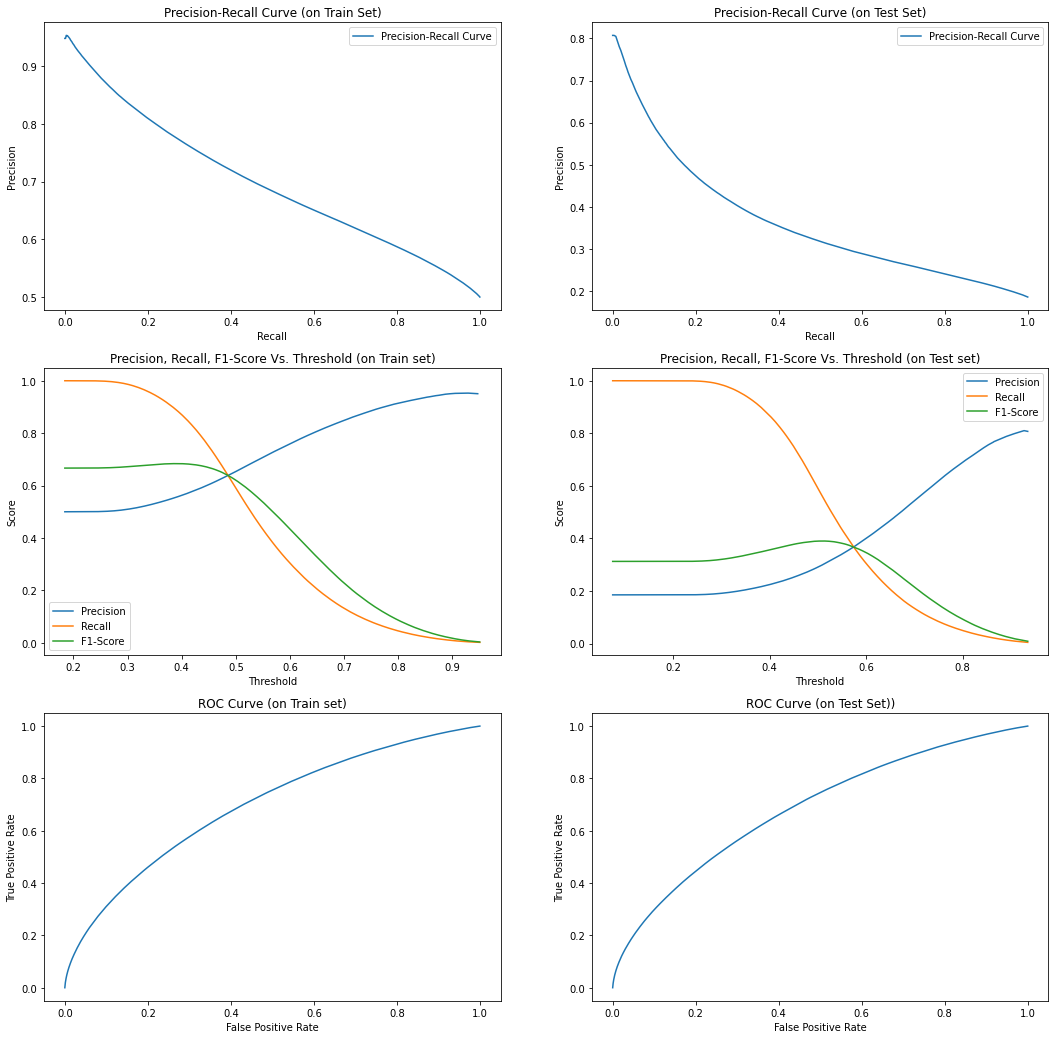

In [0]:
plotMetrics(lr_train_predictions, lr_test_predictions)

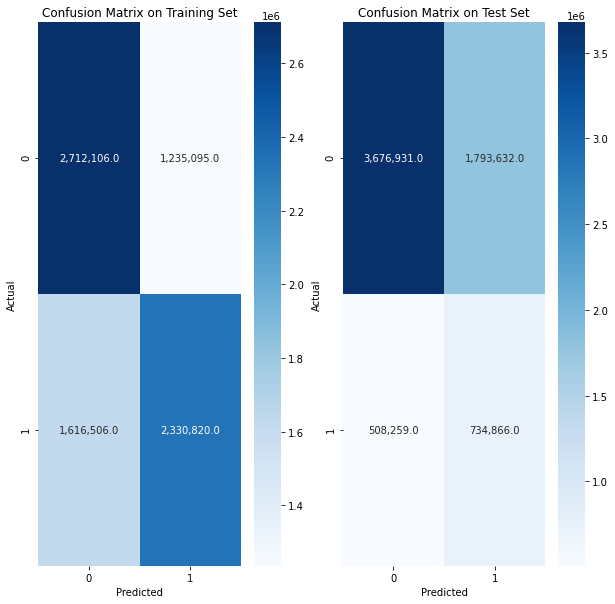

In [0]:
plotConfusionMatrix(lr_train_mcm, lr_test_mcm)

In [0]:
lr_train_predictions.unpersist()
lr_test_predictions.unpersist()

Out[58]: DataFrame[label: double, features: vector, fl_tz: timestamp, origin_icao: string, dest_icao: string, tail_num: string, fl_date: string, op_unique_carrier: string, op_carrier_airline_id: int, op_carrier_fl_num: int, year: int, quarter: int, month: int, day_of_month: int, day_of_week: int, dwnd_blk: string, dep_del15: double, dep_delay_new: double, distance: double, airport_total_flights_pwnd: double, airport_delayed_flights_pwnd: double, airport_delayed_mins_pwnd: double, airport_pct_flight_delayed: double, airline_total_flights_pwnd: double, airline_delayed_flights_pwnd: double, airline_delayed_mins_pwnd: double, airline_pct_flight_delayed: double, ripple_effect_delay: double, timediff_prev_flight: double, avg_wind_directional_angle: double, avg_wind_directional_speed_rate: double, avg_sky_ceiling_height_dimension: double, avg_vis_distance: double, avg_air_temperature: double, avg_dew_point_temperature: double, avg_sea_level_pressure: double, avg_lp_period_qty: double, avg_ap_altimeter_setting_rate: double, avg_sky_height_dimension: double, min_wind_directional_angle: double, min_wind_directional_speed_rate: double, min_sky_ceiling_height_dimension: double, min_vis_distance: double, min_air_temperature: double, min_dew_point_temperature: double, min_sea_level_pressure: double, min_lp_period_qty: double, min_ap_altimeter_setting_rate: double, min_sky_height_dimension: double, max_wind_directional_angle: double, max_wind_directional_speed_rate: double, max_sky_ceiling_height_dimension: double, max_vis_distance: double, max_air_temperature: double, max_dew_point_temperature: double, max_sea_level_pressure: double, max_lp_period_qty: double, max_ap_altimeter_setting_rate: double, max_sky_height_dimension: double, airport_pagerank: double, rawPrediction: vector, probability: vector, prediction: double]

## Decision Tree

<a id="tree"></a>

### Hyperparameter Tuning

In [0]:
tree_estimator = DecisionTreeClassifier(featuresCol='features', labelCol='label')

tree_param_grid = ParamGridBuilder() \
    .addGrid(tree_estimator.maxDepth, [2, 5, 10]) \
    .addGrid(tree_estimator.maxBins, [10, 20, 40]) \
    .build()

tree_random_grid = RandomGridBuilder(5) \
                .addDistr(tree_estimator.maxDepth, lambda: np.random.randint(2, 24)) \
                .addDistr(tree_estimator.maxBins, lambda: np.random.randint(2, 100)) \
                .build()

tree_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')

In [0]:
tree_cv_model, tree_hyperparameters = cross_validate(mdf, tree_estimator, tree_random_grid, tree_evaluator)

[{Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 17, Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 31}, {Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6, Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 51}, {Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 18, Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 12}, {Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20, Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 52}, {Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15, Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10}]
fold 1 start...
fold 1 end
fold 2 start...
fold 2 end
fold 3 start...
fold 3 end
fold 4 start...
fold 4 end
fold 5 start...
fold 5 end
fold 6 start...
fold 6 end
Best Model: {Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 18, Param(parent='DecisionTreeClassifier_64fb924e342c', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 12} Detailed Score [0.46122282672465453, 0.47311444415852066, 0.4893692017625694, 0.48031012817683494, 0.44383269769959005, 0.4603418803796114] Avg Score 0.46803186315029677

In [0]:
print(tree_cv_model)
print(tree_hyperparameters)

CrossValidatorModel_a097a06628ca
{'maxDepth': 18, 'maxBins': 12}

### Model Training and Evaluation with Best Cross-Validated Hyperparameters

In [0]:
# train the model with the best hyperparameters from CV on 2015-2018 dataset
tree_estimator = DecisionTreeClassifier(featuresCol='features', 
                                        labelCol='label',
                                        maxDepth=tree_hyperparameters.get('maxDepth', 10),
                                        maxBins=tree_hyperparameters.get('maxBins', 32)
                                       )
tree_model = train_model(tree_estimator, tx_train_df)

In [0]:
tree_model.write().overwrite().save(f'{blob_url}/tree.model')

In [0]:
# eval the model on 2019 dataset
tree_train_predictions, tree_test_predictions = eval_model(tree_model, tx_train_df, tx_test_df)

In [0]:
tree_results_df, tree_train_bcm, tree_test_bcm, tree_train_mcm, tree_test_mcm = metrics(tree_train_predictions, tree_test_predictions)

In [0]:
print(tree_results_df.T)

Training Test
Area Under ROC 0.733856 0.673298
Area Under PR 0.744028 0.317968
F1 score 0.654757 0.383275
Recall 0.630703 0.592206
Precision 0.680718 0.283319
Accuracy 0.667435 0.647111

### Plots

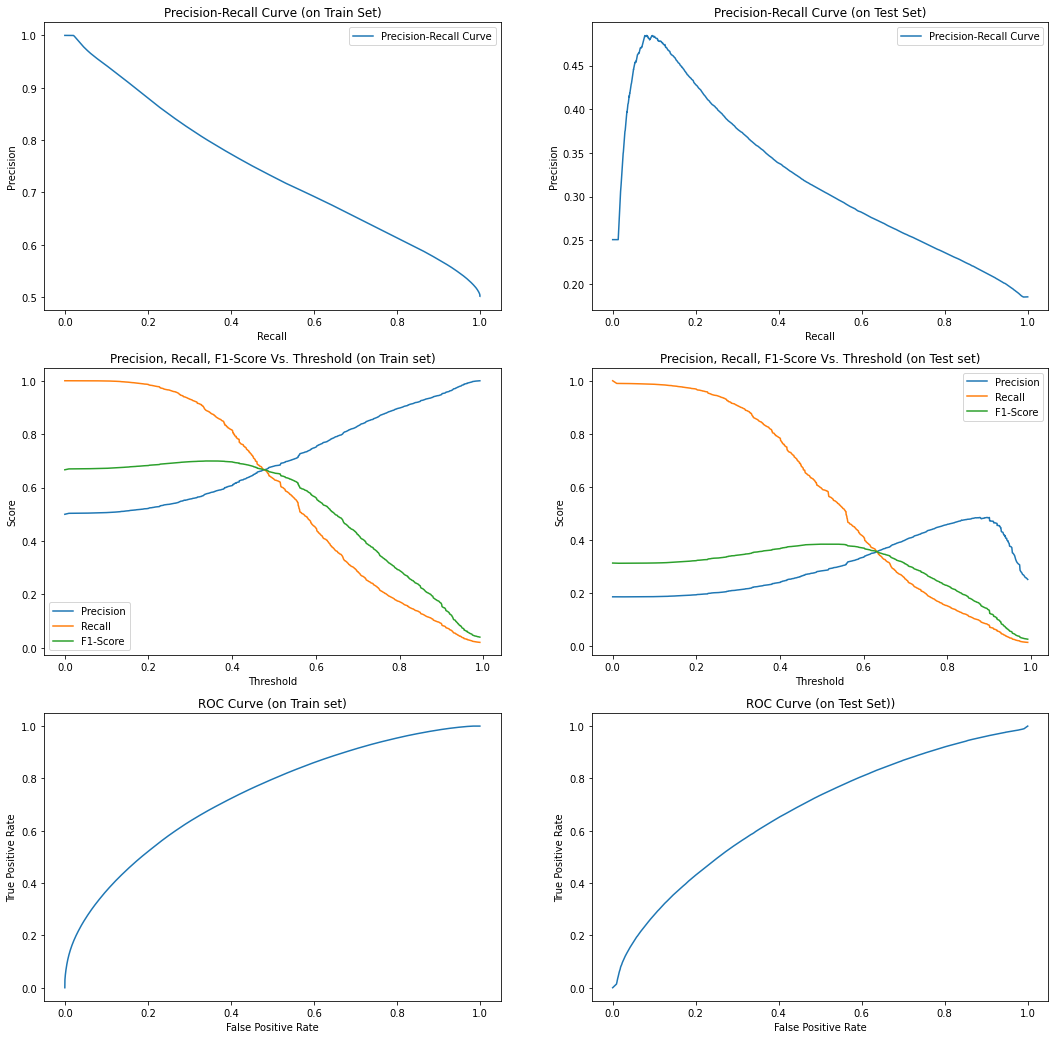

In [0]:
plotMetrics(tree_train_predictions, tree_test_predictions)

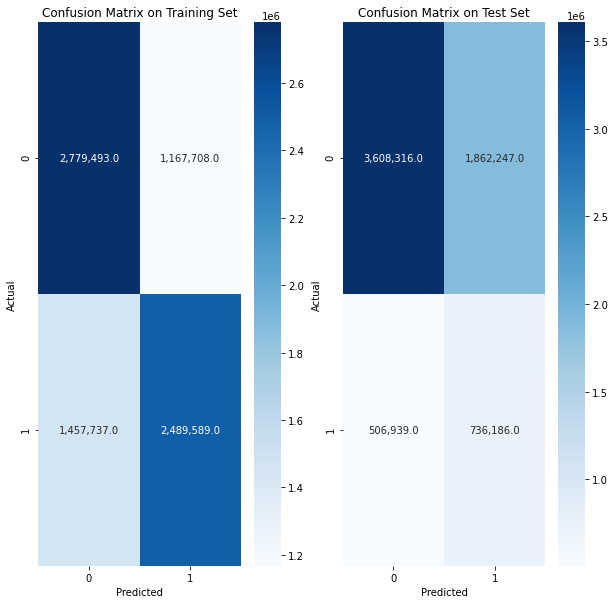

In [0]:
plotConfusionMatrix(tree_train_mcm, tree_test_mcm)

In [0]:
tree_model.featureImportances

Out[69]: SparseVector(138, {0: 0.0094, 1: 0.0831, 2: 0.0099, 3: 0.022, 4: 0.0098, 5: 0.0075, 6: 0.01, 7: 0.0076, 8: 0.0705, 9: 0.3445, 10: 0.0055, 11: 0.0041, 12: 0.0058, 13: 0.0022, 14: 0.0035, 15: 0.0173, 16: 0.0169, 17: 0.0108, 18: 0.0297, 19: 0.0005, 20: 0.0023, 21: 0.0062, 22: 0.0072, 23: 0.0061, 24: 0.0067, 25: 0.0163, 27: 0.0022, 28: 0.0045, 29: 0.0036, 30: 0.0019, 31: 0.0275, 32: 0.0045, 33: 0.0069, 34: 0.0036, 35: 0.0048, 36: 0.0052, 37: 0.0061, 38: 0.0028, 39: 0.0001, 40: 0.0019, 41: 0.0031, 42: 0.0008, 43: 0.0016, 44: 0.0027, 45: 0.001, 46: 0.0014, 47: 0.0013, 48: 0.0015, 49: 0.0008, 50: 0.0018, 51: 0.0008, 52: 0.0009, 53: 0.005, 54: 0.0015, 55: 0.0011, 56: 0.0009, 57: 0.0008, 58: 0.0009, 59: 0.0009, 60: 0.0008, 61: 0.0009, 62: 0.001, 63: 0.0008, 64: 0.0009, 65: 0.0009, 66: 0.0009, 67: 0.001, 68: 0.0012, 69: 0.0009, 70: 0.0009, 71: 0.0014, 72: 0.0008, 73: 0.0011, 74: 0.001, 75: 0.001, 76: 0.0009, 77: 0.0009, 78: 0.001, 79: 0.0008, 80: 0.001, 81: 0.0009, 82: 0.0009, 83: 0.0009, 84: 0.001, 85: 0.0011, 86: 0.001, 87: 0.0009, 88: 0.0005, 89: 0.002, 90: 0.002, 91: 0.002, 92: 0.0015, 93: 0.0015, 94: 0.0015, 95: 0.002, 96: 0.0184, 97: 0.016, 98: 0.002, 99: 0.0022, 100: 0.0011, 101: 0.0016, 102: 0.0067, 103: 0.0008, 104: 0.0037, 105: 0.001, 106: 0.0035, 107: 0.0006, 108: 0.0004, 109: 0.0003, 110: 0.0005, 111: 0.0004, 112: 0.0002, 113: 0.0001, 114: 0.0001, 115: 0.022, 116: 0.0146, 117: 0.0099, 118: 0.0009, 119: 0.0041, 120: 0.0023, 121: 0.0019, 122: 0.0007, 123: 0.0052, 124: 0.0012, 125: 0.0009, 126: 0.0012, 127: 0.0008, 128: 0.001, 129: 0.0009, 130: 0.0121, 131: 0.0008, 132: 0.0005, 133: 0.0002, 134: 0.0001})

In [0]:
tree_train_predictions.unpersist()
tree_test_predictions.unpersist()

Out[70]: DataFrame[label: double, features: vector, fl_tz: timestamp, origin_icao: string, dest_icao: string, tail_num: string, fl_date: string, op_unique_carrier: string, op_carrier_airline_id: int, op_carrier_fl_num: int, year: int, quarter: int, month: int, day_of_month: int, day_of_week: int, dwnd_blk: string, dep_del15: double, dep_delay_new: double, distance: double, airport_total_flights_pwnd: double, airport_delayed_flights_pwnd: double, airport_delayed_mins_pwnd: double, airport_pct_flight_delayed: double, airline_total_flights_pwnd: double, airline_delayed_flights_pwnd: double, airline_delayed_mins_pwnd: double, airline_pct_flight_delayed: double, ripple_effect_delay: double, timediff_prev_flight: double, avg_wind_directional_angle: double, avg_wind_directional_speed_rate: double, avg_sky_ceiling_height_dimension: double, avg_vis_distance: double, avg_air_temperature: double, avg_dew_point_temperature: double, avg_sea_level_pressure: double, avg_lp_period_qty: double, avg_ap_altimeter_setting_rate: double, avg_sky_height_dimension: double, min_wind_directional_angle: double, min_wind_directional_speed_rate: double, min_sky_ceiling_height_dimension: double, min_vis_distance: double, min_air_temperature: double, min_dew_point_temperature: double, min_sea_level_pressure: double, min_lp_period_qty: double, min_ap_altimeter_setting_rate: double, min_sky_height_dimension: double, max_wind_directional_angle: double, max_wind_directional_speed_rate: double, max_sky_ceiling_height_dimension: double, max_vis_distance: double, max_air_temperature: double, max_dew_point_temperature: double, max_sea_level_pressure: double, max_lp_period_qty: double, max_ap_altimeter_setting_rate: double, max_sky_height_dimension: double, airport_pagerank: double, rawPrediction: vector, probability: vector, prediction: double]

## Gradient Boosted Trees

<a id="gbtree"> </a>

### Hyperparameter Tuning

In [0]:
gbtree_estimator = GBTClassifier(featuresCol='features', 
                                 labelCol='label',
                                 maxIter=5,
                                 maxBins=32
                                )

gbtree_random_grid = RandomGridBuilder(2) \
                      .addDistr(gbtree_estimator.maxDepth, lambda: np.random.randint(10)) \
                      .build()

gbtree_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')

In [0]:
gbtree_cv_model, gbtree_hyperparameters = cross_validate(mdf, gbtree_estimator, gbtree_random_grid, gbtree_evaluator)

[{Param(parent='GBTClassifier_2d2b83e8aa4a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2}, {Param(parent='GBTClassifier_2d2b83e8aa4a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 1}]
fold 1 start...
fold 1 end
fold 2 start...
fold 2 end
fold 3 start...
fold 3 end
fold 4 start...
fold 4 end
fold 5 start...
fold 5 end
fold 6 start...
fold 6 end
Best Model: {Param(parent='GBTClassifier_2d2b83e8aa4a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2} Detailed Score [0.6754186554765631, 0.6714048127320026, 0.6748334796121651, 0.6757689037958196, 0.6776788431384204, 0.6758738868101963] Avg Score 0.6751630969275279

In [0]:
print(gbtree_cv_model)
print(gbtree_hyperparameters)

CrossValidatorModel_18ebc0435b6a
{'maxDepth': 2}

### Model Training and Evaluation with Best Cross-Validated Hyperparameters

In [0]:
# train the model with the best hyperparameters from CV on 2015-2018 dataset
gbtree_estimator = GBTClassifier(featuresCol='features', 
                                 labelCol='label',
                                 maxDepth=gbtree_hyperparameters.get('maxDepth', 10),
                                )
gbtree_model = train_model(gbtree_estimator, tx_train_df)

In [0]:
gbtree_model.write().overwrite().save(f'{blob_url}/gbtree.model')

In [0]:
gbtree_train_predictions, gbtree_test_predictions = eval_model(gbtree_model, tx_train_df, tx_test_df)

In [0]:
gbtree_results_df, gbtree_train_bcm, gbtree_test_bcm, gbtree_train_mcm, gbtree_test_mcm = metrics(gbtree_train_predictions, gbtree_test_predictions)

In [0]:
print(gbtree_results_df.T)

Training Test
Area Under ROC 0.678842 0.670607
Area Under PR 0.684207 0.346511
F1 score 0.573082 0.375564
Recall 0.505789 0.515503
Precision 0.661029 0.295380
Accuracy 0.623206 0.682592

### Plots

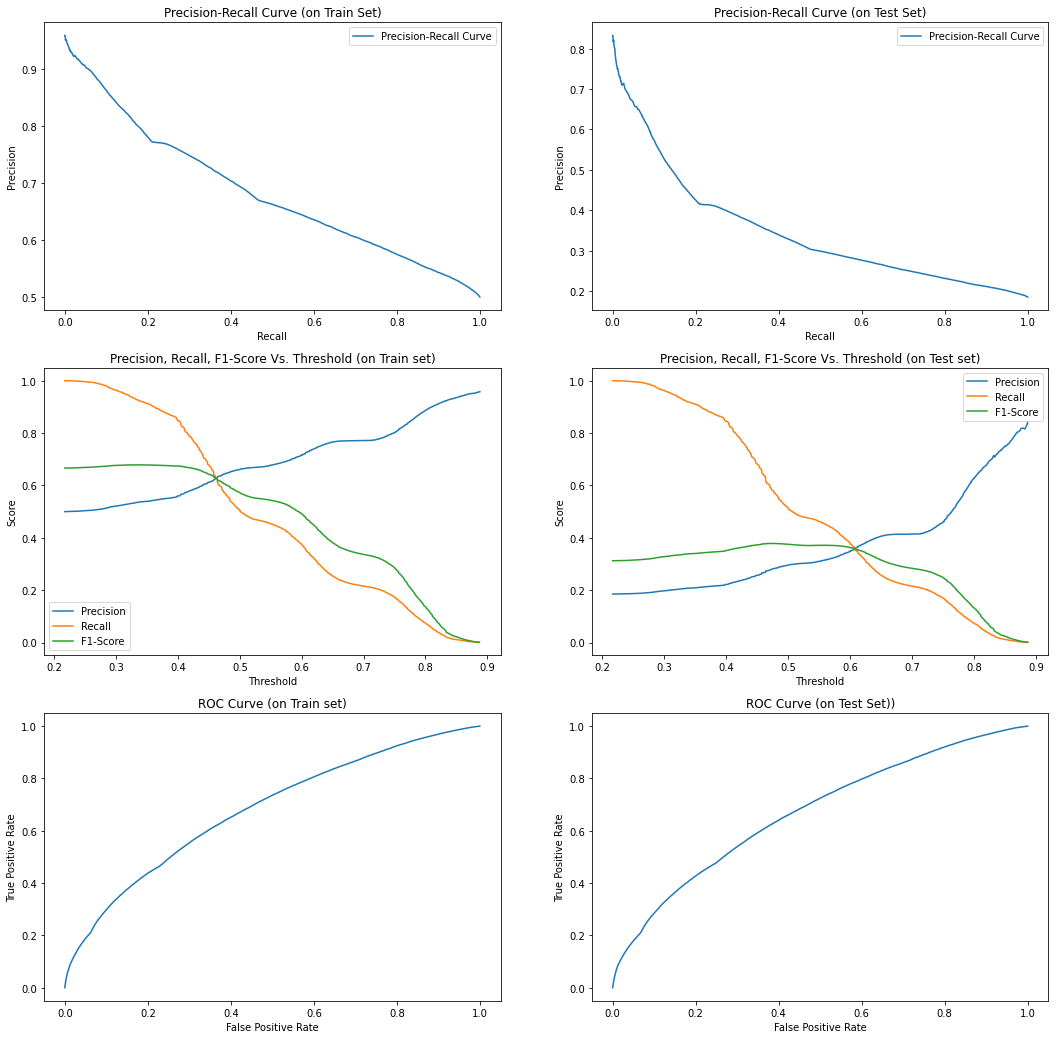

In [0]:
plotMetrics(gbtree_train_predictions, gbtree_test_predictions)

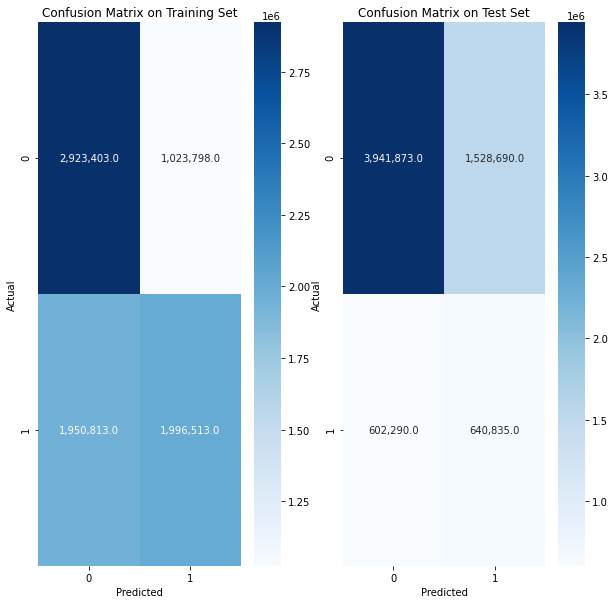

In [0]:
plotConfusionMatrix(gbtree_train_mcm, gbtree_test_mcm)

In [0]:
gbtree_train_predictions.unpersist()
gbtree_test_predictions.unpersist()

Out[81]: DataFrame[label: double, features: vector, fl_tz: timestamp, origin_icao: string, dest_icao: string, tail_num: string, fl_date: string, op_unique_carrier: string, op_carrier_airline_id: int, op_carrier_fl_num: int, year: int, quarter: int, month: int, day_of_month: int, day_of_week: int, dwnd_blk: string, dep_del15: double, dep_delay_new: double, distance: double, airport_total_flights_pwnd: double, airport_delayed_flights_pwnd: double, airport_delayed_mins_pwnd: double, airport_pct_flight_delayed: double, airline_total_flights_pwnd: double, airline_delayed_flights_pwnd: double, airline_delayed_mins_pwnd: double, airline_pct_flight_delayed: double, ripple_effect_delay: double, timediff_prev_flight: double, avg_wind_directional_angle: double, avg_wind_directional_speed_rate: double, avg_sky_ceiling_height_dimension: double, avg_vis_distance: double, avg_air_temperature: double, avg_dew_point_temperature: double, avg_sea_level_pressure: double, avg_lp_period_qty: double, avg_ap_altimeter_setting_rate: double, avg_sky_height_dimension: double, min_wind_directional_angle: double, min_wind_directional_speed_rate: double, min_sky_ceiling_height_dimension: double, min_vis_distance: double, min_air_temperature: double, min_dew_point_temperature: double, min_sea_level_pressure: double, min_lp_period_qty: double, min_ap_altimeter_setting_rate: double, min_sky_height_dimension: double, max_wind_directional_angle: double, max_wind_directional_speed_rate: double, max_sky_ceiling_height_dimension: double, max_vis_distance: double, max_air_temperature: double, max_dew_point_temperature: double, max_sea_level_pressure: double, max_lp_period_qty: double, max_ap_altimeter_setting_rate: double, max_sky_height_dimension: double, airport_pagerank: double, rawPrediction: vector, probability: vector, prediction: double]

## XG Boost Classifier

<a id="xgboost"></a>

### Hyperparameter Tuning

In [0]:
xgboost_estimator = XgboostClassifier(featuresCol='features', 
                                      labelCol='label',
                                      missing=0.0,
                                      eval_metric='logloss')

xgboost_random_grid = RandomGridBuilder(3) \
                      .addDistr(xgboost_estimator.max_depth, lambda: np.random.randint(2, 10)) \
                      .addDistr(xgboost_estimator.n_estimators, lambda: np.random.randint(10, 200)) \
                      .build()

xgboost_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')

In [0]:
xgboost_cv_model, xgboost_hyperparameters = cross_validate(mdf, xgboost_estimator, xgboost_random_grid, xgboost_evaluator)

[{Param(parent='XgboostClassifier_e050a7a55069', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 9, Param(parent='XgboostClassifier_e050a7a55069', name='n_estimators', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators'): 84}, {Param(parent='XgboostClassifier_e050a7a55069', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 6, Param(parent='XgboostClassifier_e050a7a55069', name='n_estimators', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators'): 32}, {Param(parent='XgboostClassifier_e050a7a55069', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 4, Param(parent='XgboostClassifier_e050a7a55069', name='n_estimators', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators'): 130}]
fold 1 start...
fold 1 end
fold 2 start...
fold 2 end
fold 3 start...
fold 3 end
fold 4 start...
fold 4 end
fold 5 start...
fold 5 end
fold 6 start...
fold 6 end
Best Model: {Param(parent='XgboostClassifier_e050a7a55069', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 6, Param(parent='XgboostClassifier_e050a7a55069', name='n_estimators', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators'): 32} Detailed Score [0.6963077619909093, 0.6949009416481763, 0.696367553339501, 0.7000964730335635, 0.6977358951648319, 0.7065091518642255] Avg Score 0.6986529628402012

In [0]:
print(xgboost_cv_model)
print(xgboost_hyperparameters)

CrossValidatorModel_0ea178f676f5
{'max_depth': 6, 'n_estimators': 32}

### Model Training and Evaluation with Best Cross-Validated Hyperparameters

In [0]:
# train the model with the best hyperparameters from CV on 2015-2018 dataset
xgboost_estimator = XgboostClassifier(featuresCol='features', 
                                      labelCol='label',
                                      max_depth=xgboost_hyperparameters.get('max_depth', 10),
                                      n_estimators=xgboost_hyperparameters.get('n_estimators', 32),
                                      missing=0.0,
                                      eval_metric='logloss'
                                     )
xgboost_model = train_model(xgboost_estimator, tx_train_df)

In [0]:
xgboost_model.write().overwrite().save(f'{blob_url}/xgboost.model')

In [0]:
xgboost_train_predictions, xgboost_test_predictions = eval_model(xgboost_model, tx_train_df, tx_test_df)

In [0]:
xgboost_results_df, xgboost_train_bcm, xgboost_test_bcm, xgboost_train_mcm, xgboost_test_mcm = metrics(xgboost_train_predictions, xgboost_test_predictions)

In [0]:
print(xgboost_results_df.T)

Training Test
Area Under ROC 0.712501 0.699037
Area Under PR 0.717967 0.386705
F1 score 0.638829 0.400001
Recall 0.614620 0.612218
Precision 0.665024 0.297037
Accuracy 0.652511 0.659922

### Plots

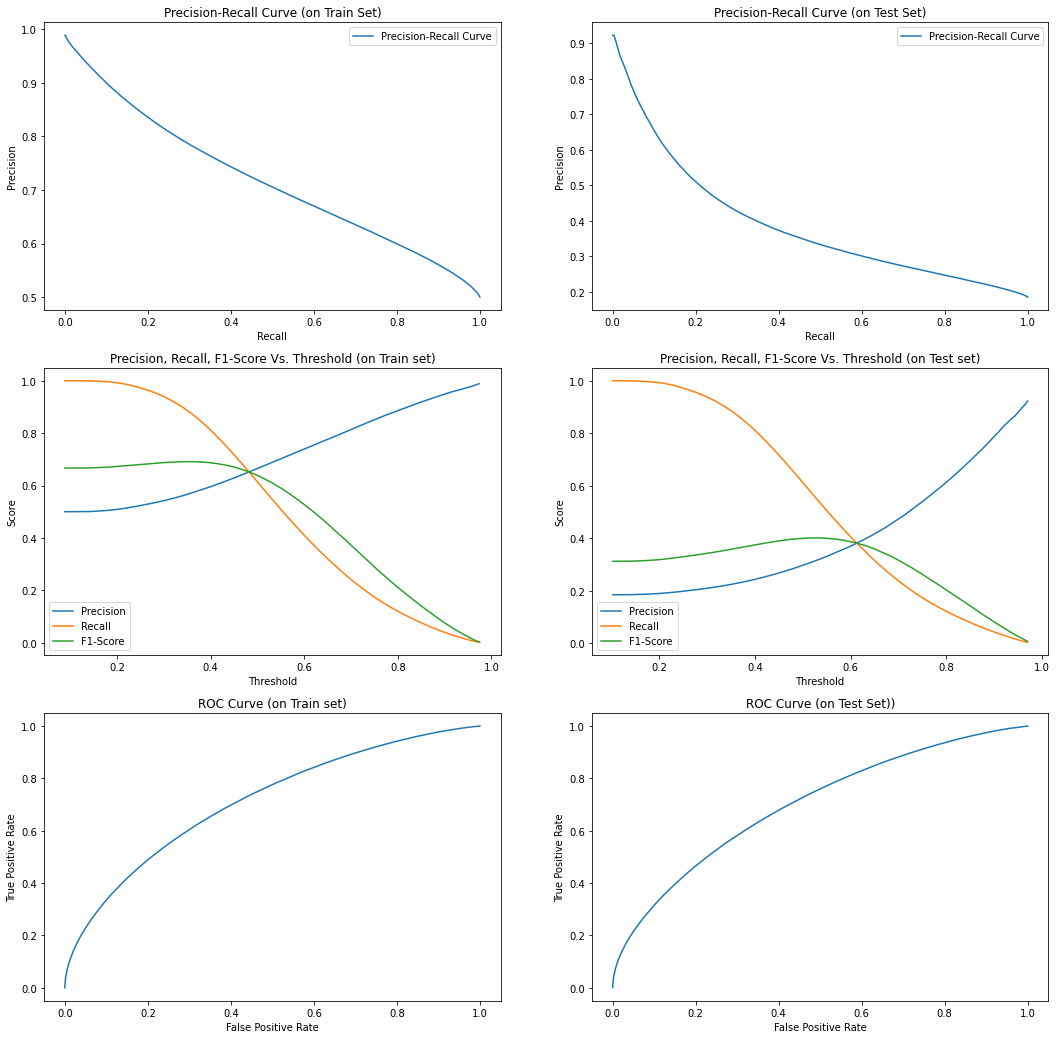

In [0]:
plotMetrics(xgboost_train_predictions, xgboost_test_predictions)

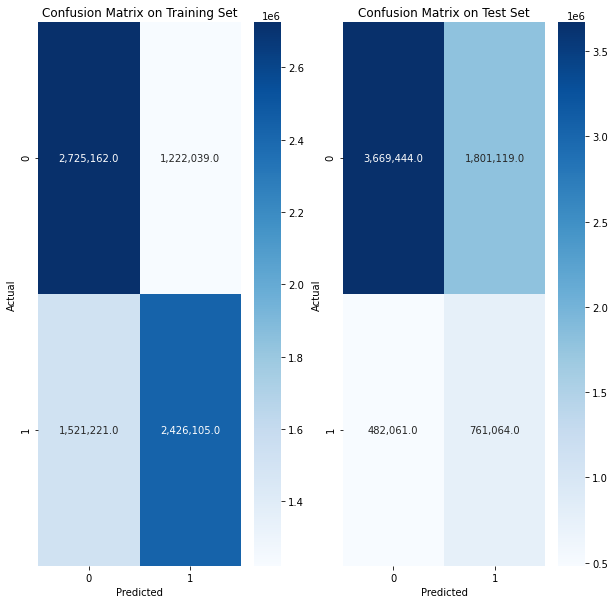

In [0]:
plotConfusionMatrix(xgboost_train_mcm, xgboost_test_mcm)

In [0]:
xgboost_train_predictions.unpersist()
xgboost_test_predictions.unpersist()

Out[92]: DataFrame[label: double, features: vector, fl_tz: timestamp, origin_icao: string, dest_icao: string, tail_num: string, fl_date: string, op_unique_carrier: string, op_carrier_airline_id: int, op_carrier_fl_num: int, year: int, quarter: int, month: int, day_of_month: int, day_of_week: int, dwnd_blk: string, dep_del15: double, dep_delay_new: double, distance: double, airport_total_flights_pwnd: double, airport_delayed_flights_pwnd: double, airport_delayed_mins_pwnd: double, airport_pct_flight_delayed: double, airline_total_flights_pwnd: double, airline_delayed_flights_pwnd: double, airline_delayed_mins_pwnd: double, airline_pct_flight_delayed: double, ripple_effect_delay: double, timediff_prev_flight: double, avg_wind_directional_angle: double, avg_wind_directional_speed_rate: double, avg_sky_ceiling_height_dimension: double, avg_vis_distance: double, avg_air_temperature: double, avg_dew_point_temperature: double, avg_sea_level_pressure: double, avg_lp_period_qty: double, avg_ap_altimeter_setting_rate: double, avg_sky_height_dimension: double, min_wind_directional_angle: double, min_wind_directional_speed_rate: double, min_sky_ceiling_height_dimension: double, min_vis_distance: double, min_air_temperature: double, min_dew_point_temperature: double, min_sea_level_pressure: double, min_lp_period_qty: double, min_ap_altimeter_setting_rate: double, min_sky_height_dimension: double, max_wind_directional_angle: double, max_wind_directional_speed_rate: double, max_sky_ceiling_height_dimension: double, max_vis_distance: double, max_air_temperature: double, max_dew_point_temperature: double, max_sea_level_pressure: double, max_lp_period_qty: double, max_ap_altimeter_setting_rate: double, max_sky_height_dimension: double, airport_pagerank: double, rawPrediction: vector, prediction: double, probability: vector]